In [154]:
!pip install seaborn wordcloud spacy kneed
!python -m spacy download en_core_web_sm
!pip install kneed

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
sns.set_style('whitegrid')

# data preprocessing
import re
import json
import string
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# modeling
from sklearn.cluster import KMeans
from kneed import KneeLocator

# utility
from collections import Counter
from itertools import chain
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [155]:
import nltk
nltk.download('stopwords')

# global variable
dataset = 'goodreads.csv'
stopwords = set(stopwords.words('english'))
punctuation = string.punctuation + '—'
min_rating = 2000000
nlp = spacy.load("en_core_web_sm")
vectorizer = TfidfVectorizer()
kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}
sse = []
n_k = range(1, 41)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading
---

In [156]:
df = pd.read_csv(dataset) \
    .drop(['web-scraper-order', 'web-scraper-start-url', 'genre', 'genre-href', 'book', 'book-href'], axis=1)
df.head()

,title,author,description,rating,total_rating,list_genre
0,Insurgent,Veronica Roth,"One choice can transform you—or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves—and herself—while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love.\n\nTris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable—and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so.\n\nNew York Times bestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Dystopia""},{""list_genre"":""Fiction""},{""list_genre"":""Fantasy""},{""list_genre"":""Science Fiction""},{""list_genre"":""Romance""},{""list_genre"":""Adventure""},{""list_genre"":""...more""}]"
1,New Moon,Stephenie Meyer,"There is an alternate cover edition for ISBN13 9780316160193 here. \n\nI knew we were both in mortal danger. Still, in that instant, I felt well. Whole. I could feel my heart racing in my chest, the blood pulsing hot and fast through my veins again. My lungs filled deep with the sweet scent that came off his skin. It was like there had never been any hole in my chest. I was perfect - not healed, but as if there had never been a wound in the first place. \n\nI FELT LIKE I WAS TRAPPED IN ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to run, run till your lungs burst, but you can't make your body move fast enough.... But this was no dream, and, unlike the nightmare, I wasn't running for my life; I was racing to save something infinitely more precious. My own life meant little to me today. \n\nFOR BELLA SWAN THERE IS ONE THING more important than life itself: Edward Cullen. But being in love with a vampire is even more dangerous than Bella could ever have imagined. Edward has already rescued Bella from the clutches of one evil vampire, but now, as their daring relationship threatens all that is near and dear to them, they realize their troubles may be just beginning....\n\nLEGIONS OF READERS ENTRANCED BY THE New York Times bestseller Twilight are hungry for the continuing story of star-crossed lovers Bell and Edward. In New Moon, Stephanie Meyer delivers another irresistible combination of romance and suspense with a supernatural spin. passionate, riveting, and full of surprising twists and turns, this vampire love saga is well on its way to literary immortality.",3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Fantasy""},{""list_genre"":""Romance""},{""list_genre"":""Vampires""},{""list_genre"":""Fiction""},{""list_genre"":""Paranormal""},{""list_genre"":""Paranormal Romance""},{""list_genre"":""...more""}]"
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster was in a fierce one-to-one duel with Lord Voldemort, and Harry can't quite believe that Professor Dumbledore will actually appear at the Dursleys' of all places. Why is the Professor coming to visit him now? What is it that cannot wait until Harry r

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1121 non-null   object 
 1   author        1121 non-null   object 
 2   description   1120 non-null   object 
 3   rating        1121 non-null   float64
 4   total_rating  1121 non-null   object 
 5   list_genre    1121 non-null   object 
dtypes: float64(1), object(5)
memory usage: 52.7+ KB


# Data Cleaning
---

Since we can't visualize with dirty data, we need to clean the data first so we can do EDA with ease. First we need to clean the *total_rating* columns and convert to int.

In [158]:
df.dropna(inplace=True)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1120 non-null   object 
 1   author        1120 non-null   object 
 2   description   1120 non-null   object 
 3   rating        1120 non-null   float64
 4   total_rating  1120 non-null   object 
 5   list_genre    1120 non-null   object 
dtypes: float64(1), object(5)
memory usage: 61.2+ KB


In [160]:
# clean the rating column by removing "ratings" and convert to int
df['total_rating_clean'] = df['total_rating'].apply(lambda x: re.sub(',(?!\s+\d$)', '', x[:-8])).astype(np.int64)
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean
0,Insurgent,Veronica Roth,"One choice can transform you—or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves—and herself—while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love.\n\nTris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable—and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so.\n\nNew York Times bestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Dystopia""},{""list_genre"":""Fiction""},{""list_genre"":""Fantasy""},{""list_genre"":""Science Fiction""},{""list_genre"":""Romance""},{""list_genre"":""Adventure""},{""list_genre"":""...more""}]",1375098
1,New Moon,Stephenie Meyer,"There is an alternate cover edition for ISBN13 9780316160193 here. \n\nI knew we were both in mortal danger. Still, in that instant, I felt well. Whole. I could feel my heart racing in my chest, the blood pulsing hot and fast through my veins again. My lungs filled deep with the sweet scent that came off his skin. It was like there had never been any hole in my chest. I was perfect - not healed, but as if there had never been a wound in the first place. \n\nI FELT LIKE I WAS TRAPPED IN ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to run, run till your lungs burst, but you can't make your body move fast enough.... But this was no dream, and, unlike the nightmare, I wasn't running for my life; I was racing to save something infinitely more precious. My own life meant little to me today. \n\nFOR BELLA SWAN THERE IS ONE THING more important than life itself: Edward Cullen. But being in love with a vampire is even more dangerous than Bella could ever have imagined. Edward has already rescued Bella from the clutches of one evil vampire, but now, as their daring relationship threatens all that is near and dear to them, they realize their troubles may be just beginning....\n\nLEGIONS OF READERS ENTRANCED BY THE New York Times bestseller Twilight are hungry for the continuing story of star-crossed lovers Bell and Edward. In New Moon, Stephanie Meyer delivers another irresistible combination of romance and suspense with a supernatural spin. passionate, riveting, and full of surprising twists and turns, this vampire love saga is well on its way to literary immortality.",3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Fantasy""},{""list_genre"":""Romance""},{""list_genre"":""Vampires""},{""list_genre"":""Fiction""},{""list_genre"":""Paranormal""},{""list_genre"":""Paranormal Romance""},{""list_genre"":""...more""}]",1747095
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster was in a fierce one-to-one duel with Lord Voldemort, and Harry can't quite believe that Professor Dumbledore will actually appear at the Dursleys' of all places. Why is the Professor coming to visit him now? What i

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 0 to 1120
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1120 non-null   object 
 1   author              1120 non-null   object 
 2   description         1120 non-null   object 
 3   rating              1120 non-null   float64
 4   total_rating        1120 non-null   object 
 5   list_genre          1120 non-null   object 
 6   total_rating_clean  1120 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 70.0+ KB


Next lets move to *list_genre* columns. We need to convert from json object to list of genre

In [162]:
# clean the genre from json object to dictionary and convert to list
df['list_genre_clean'] = df['list_genre'].apply(lambda x: [dict_genre['list_genre'] for dict_genre in json.loads(x)])
df['list_genre_clean'] = df['list_genre_clean'].apply(lambda x: ['-'.join(genre.split()) for genre in x[:-1]])
df.head()

,title,author,description,rating,total_rating,list_genre,total_rating_clean,list_genre_clean
0,Insurgent,Veronica Roth,"One choice can transform you—or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves—and herself—while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love.\n\nTris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable—and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so.\n\nNew York Times bestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Dystopia""},{""list_genre"":""Fiction""},{""list_genre"":""Fantasy""},{""list_genre"":""Science Fiction""},{""list_genre"":""Romance""},{""list_genre"":""Adventure""},{""list_genre"":""...more""}]",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Science-Fiction, Romance, Adventure]"
1,New Moon,Stephenie Meyer,"There is an alternate cover edition for ISBN13 9780316160193 here. \n\nI knew we were both in mortal danger. Still, in that instant, I felt well. Whole. I could feel my heart racing in my chest, the blood pulsing hot and fast through my veins again. My lungs filled deep with the sweet scent that came off his skin. It was like there had never been any hole in my chest. I was perfect - not healed, but as if there had never been a wound in the first place. \n\nI FELT LIKE I WAS TRAPPED IN ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to run, run till your lungs burst, but you can't make your body move fast enough.... But this was no dream, and, unlike the nightmare, I wasn't running for my life; I was racing to save something infinitely more precious. My own life meant little to me today. \n\nFOR BELLA SWAN THERE IS ONE THING more important than life itself: Edward Cullen. But being in love with a vampire is even more dangerous than Bella could ever have imagined. Edward has already rescued Bella from the clutches of one evil vampire, but now, as their daring relationship threatens all that is near and dear to them, they realize their troubles may be just beginning....\n\nLEGIONS OF READERS ENTRANCED BY THE New York Times bestseller Twilight are hungry for the continuing story of star-crossed lovers Bell and Edward. In New Moon, Stephanie Meyer delivers another irresistible combination of romance and suspense with a supernatural spin. passionate, riveting, and full of surprising twists and turns, this vampire love saga is well on its way to literary immortality.",3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""Fantasy""},{""list_genre"":""Romance""},{""list_genre"":""Vampires""},{""list_genre"":""Fiction""},{""list_genre"":""Paranormal""},{""list_genre"":""Paranormal Romance""},{""list_genre"":""...more""}]",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fiction, Paranormal, Paranormal-Romance]"
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster was in a fierce one-to-one duel

In [163]:
#removing useless columns

df.drop(['list_genre','total_rating'], axis=1, inplace=True)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1120 non-null   object 
 1   author              1120 non-null   object 
 2   description         1120 non-null   object 
 3   rating              1120 non-null   float64
 4   total_rating_clean  1120 non-null   int64  
 5   list_genre_clean    1120 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 61.2+ KB


# Exploratory Data Analysis
---

In [165]:
print(f'The goodreads dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

The goodreads dataset contains 1120 rows and 6 columns


In [166]:
print('Book unique value:', len(df['title'].unique()))
print('Author unique value:', len(df['author'].unique()))

Book unique value: 1120
Author unique value: 898


This means some authors have multiple books.

Now, checking min, max, mean, std deviation etc for rating and total ratings.

In [167]:
df.describe()

,rating,total_rating_clean
count,1120.000000,1.120000e+03
mean,4.140589,2.941330e+05
std,0.278698,7.273204e+05
min,2.000000,2.000000e+00
25%,3.960000,8.667500e+02
50%,4.150000,2.988100e+04
75%,4.340000,2.267212e+05
max,4.890000,8.889571e+06


In [168]:
def bar_chart(x, y, title=None, sc=False, xlabel=None, ylabel=None):
    """
    This function plot categorical distribution using seaborn barplot

    Parameters
    ----------
    x: x axis values
    y: y axis values
    title: title of the plot

    Returns
    ----------
    None
    """

    plt.figure(figsize=(15,8))
    if not sc:
        plt.ticklabel_format(style='plain', axis='x')
    ax = sns.barplot(x=x, y=y, palette='mako')
    ax.set_title(title, pad=20, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

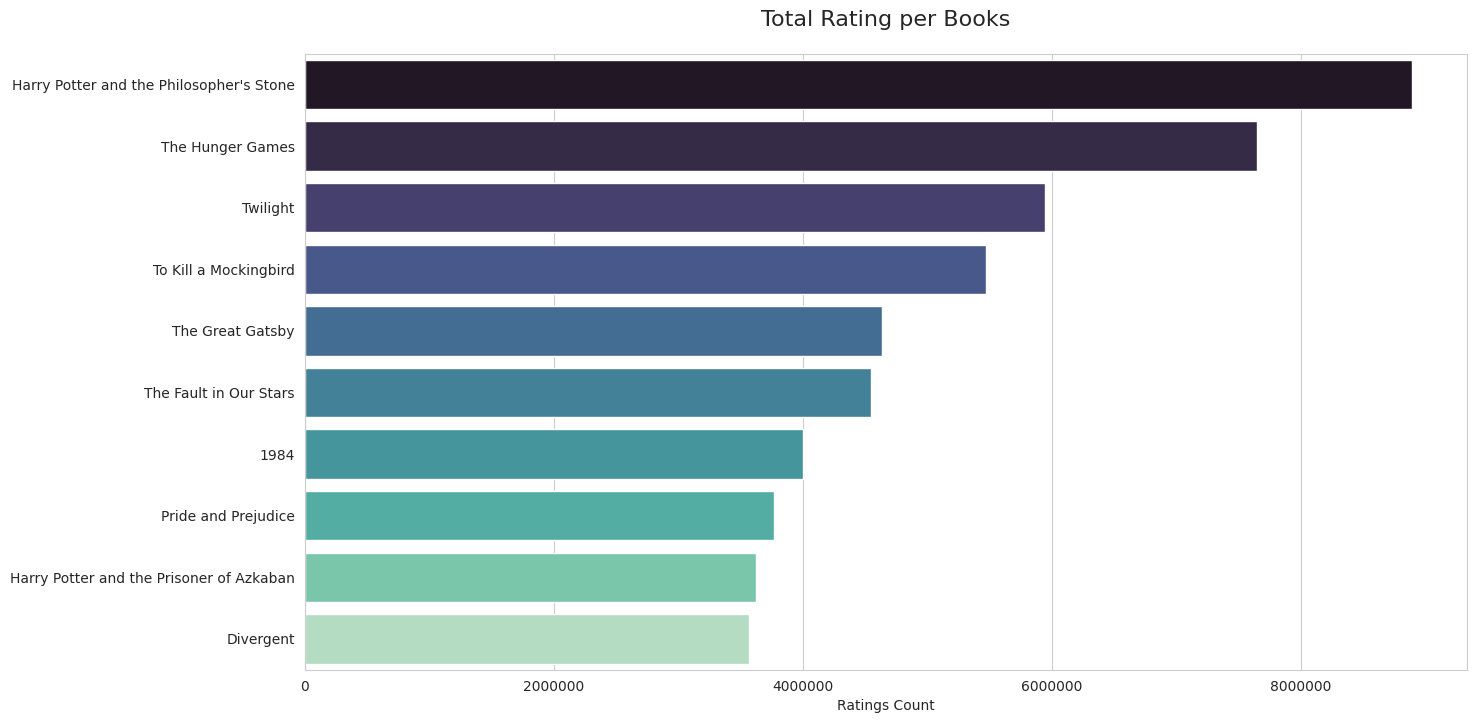

In [169]:
top_10_rated_book = df.sort_values('total_rating_clean', ascending=False).head(10).set_index('title')
bar_chart(
    x=top_10_rated_book['total_rating_clean'],
    y=top_10_rated_book.index,
    title='Total Rating per Books',
    xlabel='Ratings Count'
)

From the plot above we can conclude that:
1. Usually the beginning books of the series have the most rating, i.e Harry Potter and the Phiolosopher Stone, The Hunger Games, Twilight.
2. J.K Rowling dominates the most rated books chart with Harry Potter and the Philosopher's Stone and Harry Potter and the Prisoner of Azkaban with over than 12 million rating on GoodReads.

Now, comparing total ratings to rating.

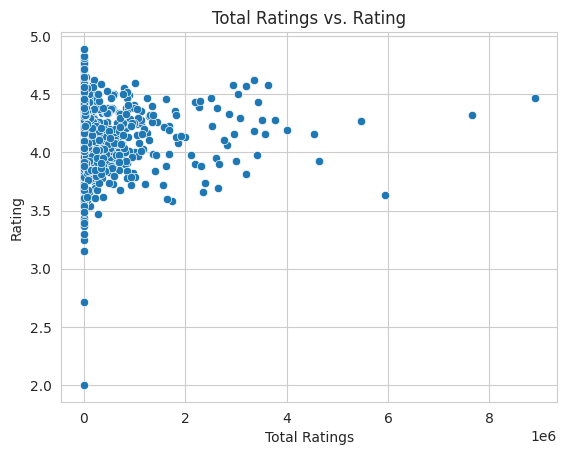

In [170]:
sns.scatterplot(data=df, x='total_rating_clean', y='rating')

plt.title('Total Ratings vs. Rating')
plt.xlabel('Total Ratings')
plt.ylabel('Rating')
plt.show()

From this plot we can compare to plot before, we can see that some book with most total rating is not in the highest rated books chart. We can conclude that having that much number of rating doesnt make the book the highest rated books.

Now, checking genre with most books

In [171]:
def create_wordcloud(data):
    """
    This function used to create wordcloud from given data

    Parameters
    ----------
    data: a set of string/text

    Returns
    ----------
    None
    """

    wordcloud = WordCloud(
        width=1500,
        height=800,
        min_font_size=12,
        background_color='white'
    ).generate(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

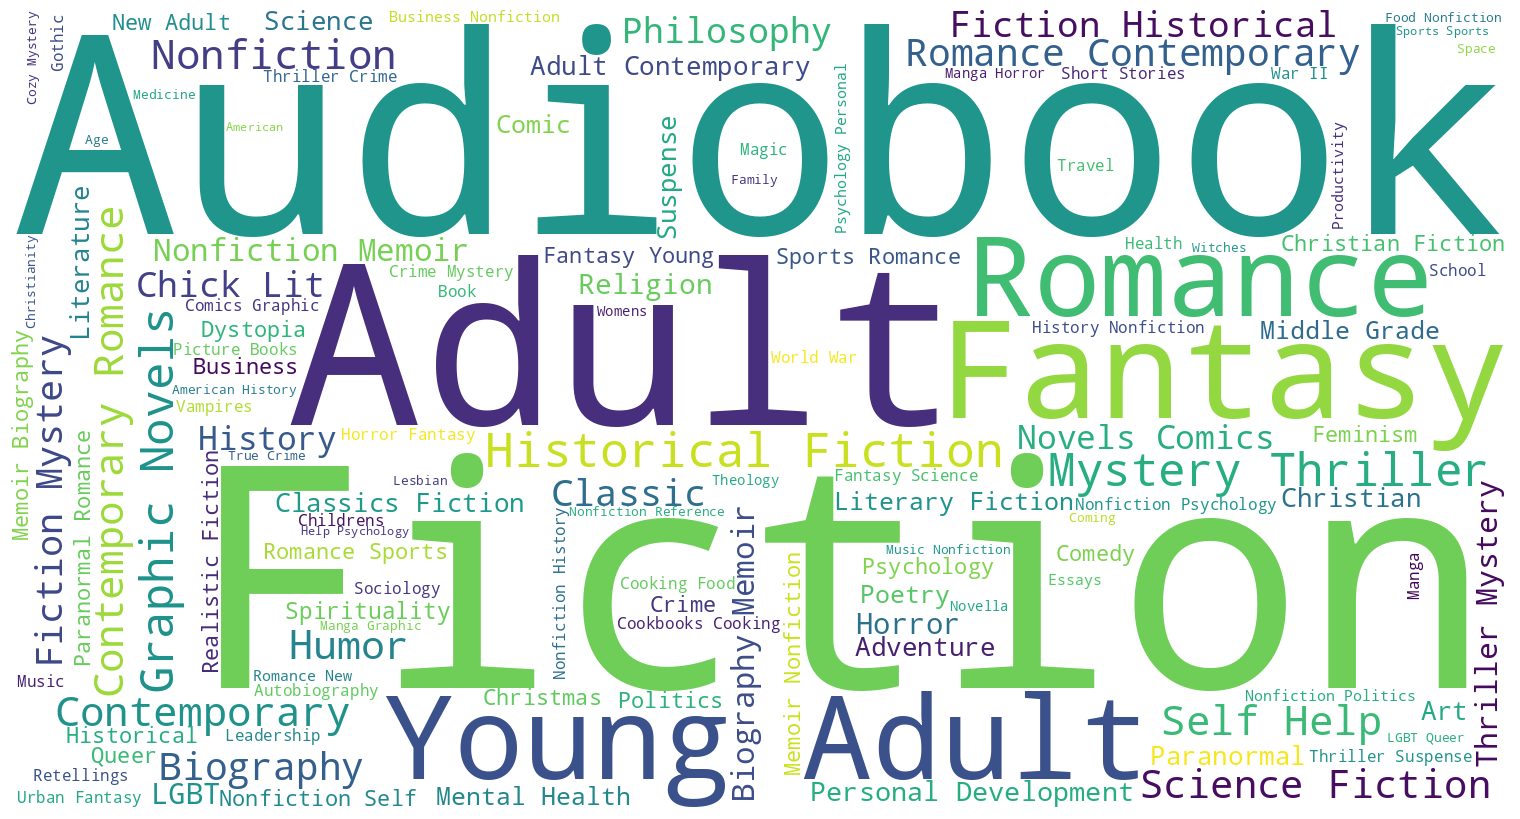

In [172]:
joined_genre = ' '.join(df['list_genre_clean'].apply(lambda x: ' '.join(x)).values)
create_wordcloud(joined_genre)

From the wordcloud above we can see that most books have Fiction genre, followed by Adult and Audiobook.

In [173]:
temp = df[~(df['total_rating_clean'] > min_rating)]
temp.head()

,title,author,description,rating,total_rating_clean,list_genre_clean
0,Insurgent,Veronica Roth,"One choice can transform you—or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves—and herself—while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love.\n\nTris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable—and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so.\n\nNew York Times bestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",3.99,1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Science-Fiction, Romance, Adventure]"
1,New Moon,Stephenie Meyer,"There is an alternate cover edition for ISBN13 9780316160193 here. \n\nI knew we were both in mortal danger. Still, in that instant, I felt well. Whole. I could feel my heart racing in my chest, the blood pulsing hot and fast through my veins again. My lungs filled deep with the sweet scent that came off his skin. It was like there had never been any hole in my chest. I was perfect - not healed, but as if there had never been a wound in the first place. \n\nI FELT LIKE I WAS TRAPPED IN ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to run, run till your lungs burst, but you can't make your body move fast enough.... But this was no dream, and, unlike the nightmare, I wasn't running for my life; I was racing to save something infinitely more precious. My own life meant little to me today. \n\nFOR BELLA SWAN THERE IS ONE THING more important than life itself: Edward Cullen. But being in love with a vampire is even more dangerous than Bella could ever have imagined. Edward has already rescued Bella from the clutches of one evil vampire, but now, as their daring relationship threatens all that is near and dear to them, they realize their troubles may be just beginning....\n\nLEGIONS OF READERS ENTRANCED BY THE New York Times bestseller Twilight are hungry for the continuing story of star-crossed lovers Bell and Edward. In New Moon, Stephanie Meyer delivers another irresistible combination of romance and suspense with a supernatural spin. passionate, riveting, and full of surprising twists and turns, this vampire love saga is well on its way to literary immortality.",3.58,1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fiction, Paranormal, Paranormal-Romance]"
15,The Road to Bittersweet,Donna Everhart,"SOUTHEASTERN LIBRARY ASSOCIATION'S (SELA) 2018 Author of the Year in fiction\nPUBLISHERS LUNCH BUZZ BOOK, Winter 2017/2018\nSIBA Trio 2018 Selection\nSIBA OKRA PICK Winter 2018\nFirst Pick for SOUTHERN LADY Book Club\n\nSet in the Carolinas in the 1940s, The Road to Bittersweet is a beautifully written, evocative account of a young woman reckoning not just with the unforgiving landscape, but with the rocky emotional terrain that leads from innocence to wisdom.\n\nFor fourteen-year-old Wallis Ann Stamper and her family, life in the Appalachian Mountains is simple and satisfying, though not for the tenderhearted. While her older sister, Laci—a mute, musically gifted savant—is constantly watched over and protected, Wallis Ann is as practical and sturdy as her name. When the Tuckasegee River bursts its banks, forcing them to flee in the middle of the night, those qualities save her

# Feature Selection and extraction
---

Because we are using Content Based Approach, the feature we are subseting is title, author, genre, and keywords.

In [174]:
def strip_html(text):
    """
    This function strip html tags from text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: cleaned text from html
    """

    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stopwords(text):
    """
    This function remove stopwords from text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: cleaned text from stopwords
    """

    text = text.split()
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

def remove_digits(text):
    """
    This function remove number/digits from text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: cleaned text from number/digits
    """

    text = re.sub(r'[0-9]', '', text)
    return text

def remove_punctuation(text):
    """
    This function remove punctuation from text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: cleaned text from punctuation
    """

    text = ''.join([word for word in text if word not in punctuation])
    return text

def get_keywords(text):
    """
    This function get keywords from text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: list of keywords
    """

    doc = nlp(text)
    return ' '.join([item.text.strip() for item in doc.ents])

def parse_text(text):
    """
    This function parse the text

    Parameters
    ----------
    text: some text

    Returns
    ----------
    text: parsed text
    """

    text = text.lower()
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_punctuation(text)
    text = get_keywords(text)
    return text

In [175]:
df['keywords'] = df['description'].apply(parse_text)
df.head()

,title,author,description,rating,total_rating_clean,list_genre_clean,keywords
0,Insurgent,Veronica Roth,"One choice can transform you—or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves—and herself—while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love.\n\nTris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable—and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so.\n\nNew York Times bestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",3.99,1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Science-Fiction, Romance, Adventure]",one triss new york second
1,New Moon,Stephenie Meyer,"There is an alternate cover edition for ISBN13 9780316160193 here. \n\nI knew we were both in mortal danger. Still, in that instant, I felt well. Whole. I could feel my heart racing in my chest, the blood pulsing hot and fast through my veins again. My lungs filled deep with the sweet scent that came off his skin. It was like there had never been any hole in my chest. I was perfect - not healed, but as if there had never been a wound in the first place. \n\nI FELT LIKE I WAS TRAPPED IN ONE OF THOSE TERRIFYING NIGHTMARES, the one where you have to run, run till your lungs burst, but you can't make your body move fast enough.... But this was no dream, and, unlike the nightmare, I wasn't running for my life; I was racing to save something infinitely more precious. My own life meant little to me today. \n\nFOR BELLA SWAN THERE IS ONE THING more important than life itself: Edward Cullen. But being in love with a vampire is even more dangerous than Bella could ever have imagined. Edward has already rescued Bella from the clutches of one evil vampire, but now, as their daring relationship threatens all that is near and dear to them, they realize their troubles may be just beginning....\n\nLEGIONS OF READERS ENTRANCED BY THE New York Times bestseller Twilight are hungry for the continuing story of star-crossed lovers Bell and Edward. In New Moon, Stephanie Meyer delivers another irresistible combination of romance and suspense with a supernatural spin. passionate, riveting, and full of surprising twists and turns, this vampire love saga is well on its way to literary immortality.",3.58,1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fiction, Paranormal, Paranormal-Romance]",first today one one new york new moon stephanie meyer
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster was in a fierce one-to-one duel with Lord Voldemort, and Harry can't quite believe that Professor Dumbledore will actually appear at the Dursleys' of all places. Why is the Professor coming to visit him now? What is it that cannot wait until Harry returns to Hogwarts in a few weeks' time? Harry's sixth year at Hogwarts has already got off to an unusual start, as the worlds of Muggle and magic start to intertwine...",4.58,2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook]",harry

In [176]:
features = ['title', 'author', 'list_genre_clean', 'keywords']
final_df = df.loc[:, features]
final_df['list_genre_clean'] = final_df['list_genre_clean'].apply(lambda x: ' '.join(x))
final_df['keywords'] = final_df['keywords'].apply(lambda x: ' '.join(list(set(x.split()))))
final_df.head()

,title,author,list_genre_clean,keywords
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-Fiction Romance Adventure,york one triss new second
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction Paranormal Paranormal-Romance,york stephanie meyer first one today moon new
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,dumbledore harry returns year one sixth potter weeks harrys
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Middle-Grade Audiobook,harry returns year one potter harry’s draco second summer
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,holidays harry year ron hermione potter fifth summer


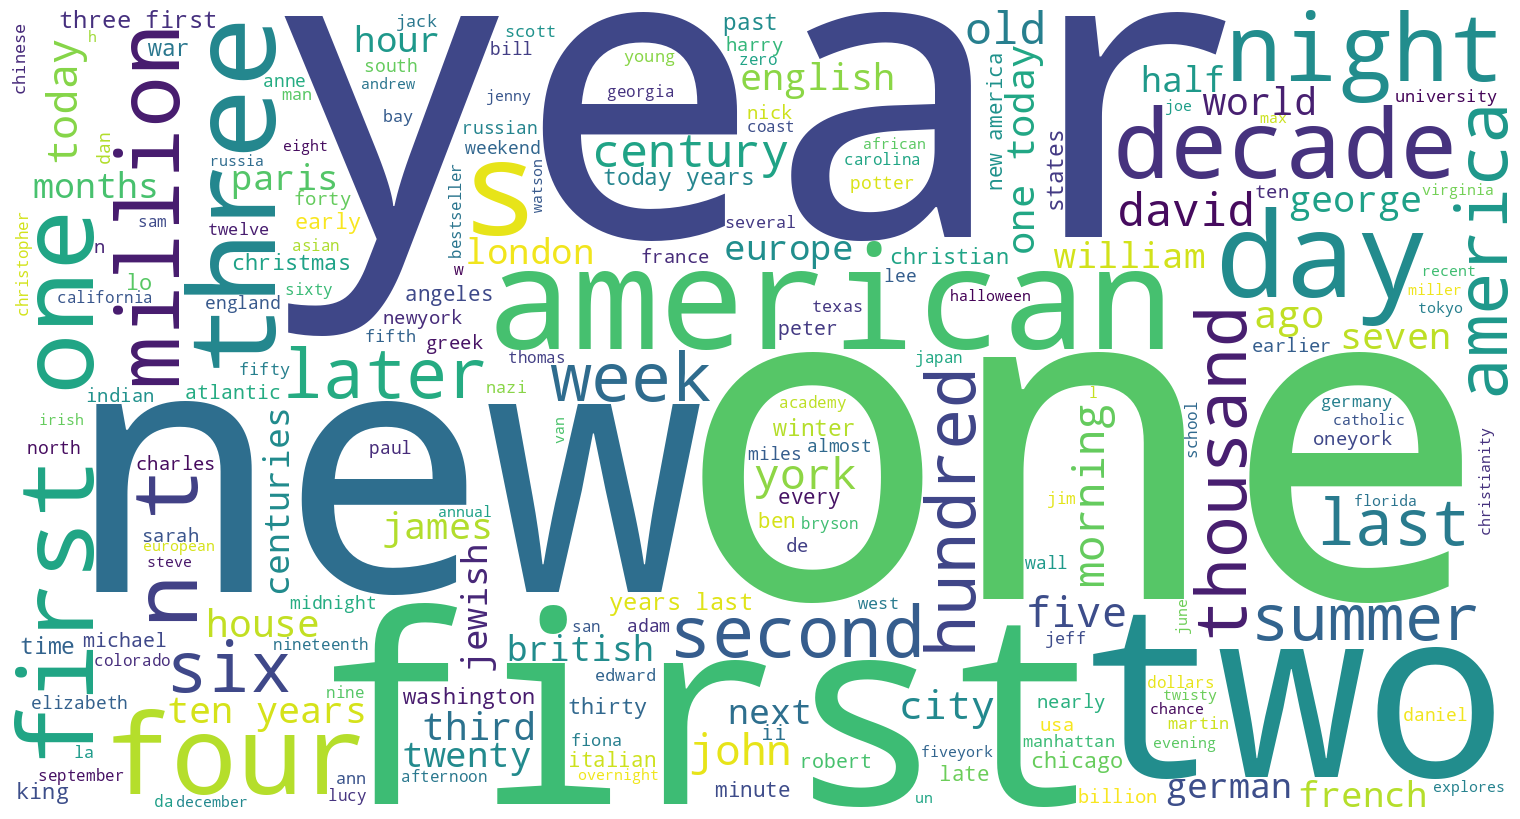

In [177]:
joined_keyword = ''.join(final_df['keywords'].values)
create_wordcloud(joined_keyword)

From the wordcloud above, we can see that "year" is the most occurred keywords of all books. It can happens because in most books description starting with telling the year of the books. Next we can create a corpus from book genre and keywords to find the frequency of corpus between books. We are using TfidfVectorizer to find the corpus frequency and convert it to vector array.

In [178]:
final_df['corpus'] =  final_df[['list_genre_clean', 'keywords']].agg(' '.join, axis=1).str.lower()
final_df.head()

,title,author,list_genre_clean,keywords,corpus
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-Fiction Romance Adventure,york one triss new second,young-adult dystopia fiction fantasy science-fiction romance adventure york one triss new second
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction Paranormal Paranormal-Romance,york stephanie meyer first one today moon new,young-adult fantasy romance vampires fiction paranormal paranormal-romance york stephanie meyer first one today moon new
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,dumbledore harry returns year one sixth potter weeks harrys,fantasy young-adult fiction magic childrens adventure audiobook dumbledore harry returns year one sixth potter weeks harrys
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Middle-Grade Audiobook,harry returns year one potter harry’s draco second summer,fantasy fiction young-adult magic childrens middle-grade audiobook harry returns year one potter harry’s draco second summer
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,holidays harry year ron hermione potter fifth summer,fantasy young-adult fiction magic childrens adventure audiobook holidays harry year ron hermione potter fifth summer


In [179]:
tfidf = vectorizer.fit_transform(final_df['corpus'])
tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15960 stored elements and shape (1120, 3447)>

# Modeling
---

After getting the frequency, then we need to find the similarity between vector for clustering. We will use cosine similarity to find similarity between vector.

In [180]:
cosine_sim = cosine_similarity(tfidf, tfidf)
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119
0,1.000000,0.231847,0.179829,0.170170,0.172100,0.236551,0.147152,0.167470,0.141770,0.285607,...,0.077192,0.081710,0.0,0.0,0.023850,0.114880,0.129700,0.000000,0.066755,0.109524
1,0.231847,1.000000,0.074733,0.072854,0.065818,0.090467,0.056277,0.064047,0.094114,0.557052,...,0.051155,0.045032,0.0,0.0,0.017711,0.059418,0.073241,0.152182,0.059714,0.066929
2,0.179829,0.074733,1.000000,0.559068,0.441109,0.543760,0.365902,0.416425,0.477081,0.080312,...,0.025176,0.022890,0.0,0.0,0.015951,0.000000,0.045534,0.000000,0.039440,0.023732
3,0.170170,0.072854,0.559068,1.000000,0.509708,0.571324,0.467327,0.580207,0.718103,0.137831,...,0.024543,0.022314,0.0,0.0,0.015550,0.039864,0.044389,0.000000,0.038448,0.023135
4,0.172100,0.065818,0.441109,0.509708,1.000000,0.573125,0.600336,0.626189,0.502845,0.084649,...,0.016823,0.024126,0.0,0.0,0.000000,0.000000,0.035028,0.000000,0.041570,0.013674



After getting the distance between item in vector, we feed the data into KMeans and run for 40 iteration to get the sse for finding the best k (elbow) using KneeLocator.

In [181]:
for k in n_k:
    print(f'Cluster {k}/40')
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(cosine_sim)
    sse.append(kmeans.inertia_)
    clear_output(wait=True)
locator = KneeLocator(n_k, sse, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator.elbow)

Best cluster for KMeans: 9


In [182]:
kmeans = KMeans(n_clusters=locator.elbow, **kmeans_params)
kmeans.fit(cosine_sim)
final_df['cluster'] = kmeans.labels_
final_df.head(15)

,title,author,list_genre_clean,keywords,corpus,cluster
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-Fiction Romance Adventure,york one triss new second,young-adult dystopia fiction fantasy science-fiction romance adventure york one triss new second,5
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction Paranormal Paranormal-Romance,york stephanie meyer first one today moon new,young-adult fantasy romance vampires fiction paranormal paranormal-romance york stephanie meyer first one today moon new,5
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,dumbledore harry returns year one sixth potter weeks harrys,fantasy young-adult fiction magic childrens adventure audiobook dumbledore harry returns year one sixth potter weeks harrys,7
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Middle-Grade Audiobook,harry returns year one potter harry’s draco second summer,fantasy fiction young-adult magic childrens middle-grade audiobook harry returns year one potter harry’s draco second summer,7
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Adventure Audiobook,holidays harry year ron hermione potter fifth summer,fantasy young-adult fiction magic childrens adventure audiobook holidays harry year ron hermione potter fifth summer,7
5,Harry Potter and the Deathly Hallows,J.K. Rowling,Young-Adult Fiction Magic Childrens Adventure Audiobook Fantasy,potter seventh harry,young-adult fiction magic childrens adventure audiobook fantasy potter seventh harry,7
6,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Middle-Grade Adventure,school harry year ron hermione potter third azkaban called guard,fantasy fiction young-adult magic childrens middle-grade adventure school harry year ron hermione potter third azkaban called guard,7
7,Harry Potter and the Goblet of Fire,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Middle-Grade Adventure,holidays days harry year potter counting summer fourth,fantasy young-adult fiction magic childrens middle-grade adventure holidays days harry year potter counting summer fourth,7
8,Harry Potter and the Philosopher's Stone,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Middle-Grade Classics,potter harry,fantasy fiction young-adult magic childrens middle-grade classics potter harry,7
9,Twilight,Stephenie Meyer,Fantasy Young-Adult Romance Fiction Vampires Paranormal Paranormal-Romance,third second three first,fantasy young-adult romance fiction vampires paranormal paranormal-romance third second three first,5


Now lets get 1 book from final_df for test the recommendation system then we create book map for getting book recommendation based on title given. And return the book index if the book given exists in dataset.

In [183]:
test_book = final_df.sample(1, random_state=13)
test_book

,title,author,list_genre_clean,keywords,corpus,cluster
249,"The Myth of Normal: Trauma, Illness, and Healing in a Toxic Culture",Gabor Maté,Nonfiction Psychology Self-Help Health Mental-Health Science Sociology,canada two half four percent today fifth europe daniel americans myth decades nearly,nonfiction psychology self-help health mental-health science sociology canada two half four percent today fifth europe daniel americans myth decades nearly,2


In [184]:
book_map = pd.Series(final_df.index, index=final_df['title'])
book_map.head()

,0
title,
Insurgent,0
New Moon,1
Harry Potter and the Half-Blood Prince,2
Harry Potter and the Chamber of Secrets,3
Harry Potter and the Order of the Phoenix,4


In [185]:
def get_recommendation(title, top_n=11):
    """
    This function get recommendation from given book title

    Parameters
    ----------
    title: a text of book title
    top_n: (default 11) how much book want to get recommendation - given book title

    Returns
    ----------
    top_n_recommendation: a DataFrame contains recommended book
    """
    top_n = top_n + 1
    # get index from input title
    book_id = book_map[title]

    # calculate similarity score, sort value descending and get top_n book
    sim_score = list(enumerate(cosine_sim[book_id]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[:top_n]

    # get book index from top_n recommendation
    book_indices = [score[0] for score in sim_score]
    scores = [score[1] for score in sim_score]
    top_n_recommendation = final_df[['title', 'author', 'list_genre_clean']].iloc[book_indices]
    top_n_recommendation['list_genre_clean'] = top_n_recommendation['list_genre_clean'].apply(lambda x: x.split())
    top_n_recommendation['score'] = scores
    top_n_recommendation.reset_index(drop=True, inplace=True)
    return top_n_recommendation[1:]

In [186]:
test_title = test_book['title'].values[0]
pd.set_option('display.max_colwidth', None)
test_df = final_df[['title', 'author', 'list_genre_clean', 'cluster']].loc[final_df['title'] == test_title]
test_df['list_genre_clean'] = test_df['list_genre_clean'].apply(lambda x: x.split())
test_df

,title,author,list_genre_clean,cluster
249,"The Myth of Normal: Trauma, Illness, and Healing in a Toxic Culture",Gabor Maté,"[Nonfiction, Psychology, Self-Help, Health, Mental-Health, Science, Sociology]",2


In [187]:
recommendation = get_recommendation(test_title)
recommendation

,title,author,list_genre_clean,score
1,The Book of Phobias and Manias: A History of Obsession,Kate Summerscale,"[Nonfiction, Psychology, History, Mental-Health, Reference, Science, Health]",0.395020
2,Clarity & Connection,Yung Pueblo,"[Poetry, Self-Help, Nonfiction, Psychology, Philosophy, Spirituality, Mental-Health]",0.349351
3,Burnout: The Secret to Unlocking the Stress Cycle,Emily Nagoski,"[Nonfiction, Self-Help, Psychology, Audiobook, Feminism, Mental-Health, Health]",0.336932
4,"The Body Keeps the Score: Brain, Mind, and Body in the Healing of Trauma",Bessel van der Kolk,"[Nonfiction, Psychology, Self-Help, Mental-Health, Health, Science, Audiobook]",0.321859
5,Home Body,Rupi Kaur,"[Poetry, Nonfiction, Feminism, Mental-Health, Adult, Contemporary, Self-Help]",0.317988
6,The Psychopath Test: A Journey Through the Madness Industry,Jon Ronson,"[Nonfiction, Psychology, Science, Mental-Health, Audiobook, Sociology, Journalism]",0.316898
7,Atlas of the Heart: Mapping Meaningful Connection and the Language of Human Experience,Brené Brown,"[Nonfiction, Self-Help, Psychology, Audiobook, Personal-Development, Mental-Health, Relationships]",0.300991
8,The Mountain Is You: Transforming Self-Sabotage Into Self-Mastery,Brianna Wiest,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Poetry, Spirituality]",0.299947
9,Master Your Emotions: A Practical Guide to Overcome Negativity and Better Manage Your Feelings,Thibaut Meurisse,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Health, Business]",0.290784
10,Living Untethered: Beyond the Human Predicament,Michael A. Singer,"[Spirituality, Nonfiction, Self-Help, Psychology, Philosophy, Personal-Development, Mental-Health]",0.289483


After getting the recommendation lets check if the recommended book is in the same cluster or not.

In [188]:
recommendation['cluster'] = recommendation['title'].apply(
    lambda x: final_df.loc[final_df['title'] == x, 'cluster'].values[0] \
    if x in final_df['title'].values.tolist() else False)
recommendation

,title,author,list_genre_clean,score,cluster
1,The Book of Phobias and Manias: A History of Obsession,Kate Summerscale,"[Nonfiction, Psychology, History, Mental-Health, Reference, Science, Health]",0.395020,2
2,Clarity & Connection,Yung Pueblo,"[Poetry, Self-Help, Nonfiction, Psychology, Philosophy, Spirituality, Mental-Health]",0.349351,2
3,Burnout: The Secret to Unlocking the Stress Cycle,Emily Nagoski,"[Nonfiction, Self-Help, Psychology, Audiobook, Feminism, Mental-Health, Health]",0.336932,2
4,"The Body Keeps the Score: Brain, Mind, and Body in the Healing of Trauma",Bessel van der Kolk,"[Nonfiction, Psychology, Self-Help, Mental-Health, Health, Science, Audiobook]",0.321859,2
5,Home Body,Rupi Kaur,"[Poetry, Nonfiction, Feminism, Mental-Health, Adult, Contemporary, Self-Help]",0.317988,2
6,The Psychopath Test: A Journey Through the Madness Industry,Jon Ronson,"[Nonfiction, Psychology, Science, Mental-Health, Audiobook, Sociology, Journalism]",0.316898,2
7,Atlas of the Heart: Mapping Meaningful Connection and the Language of Human Experience,Brené Brown,"[Nonfiction, Self-Help, Psychology, Audiobook, Personal-Development, Mental-Health, Relationships]",0.300991,2
8,The Mountain Is You: Transforming Self-Sabotage Into Self-Mastery,Brianna Wiest,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Poetry, Spirituality]",0.299947,2
9,Master Your Emotions: A Practical Guide to Overcome Negativity and Better Manage Your Feelings,Thibaut Meurisse,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Health, Business]",0.290784,2
10,Living Untethered: Beyond the Human Predicament,Michael A. Singer,"[Spirituality, Nonfiction, Self-Help, Psychology, Philosophy, Personal-Development, Mental-Health]",0.289483,2


As we can see top 10 of the recommended books are in cluster 1, and 11th one is in cluster 0. We can conclude that the recommendation give the relevant item based on given title most of the time.

# Evaluation
---

For evaluation Content Based Approach, we gonna use precision@k. Basically, count the relevant item from all recommended item. Usually precision@k use the rating, since we dont have a rating from user we gonna use the similarity score between recommended book and given book. If the score > 0.5 then the book is relevant.

In [189]:
test_cluster = test_df['cluster'].values[0]
print('The cluster for test data is:', test_cluster)

The cluster for test data is: 2


In [190]:
def get_relevant_items(recommendation,cluster):
    """
    This function used to calculate total relevant items

    Parameters
    ----------
    cluster: test cluster to get relevant item

    Returns
    ----------
    relevant_item: a dataframe contain relevant items
    """

    relevant_item = recommendation.loc[(recommendation['cluster'] == cluster)]
    return relevant_item

def get_recommended_and_relevant(recommendation, cluster):
    relevant_item = get_relevant_items(recommendation, cluster)
    recommended_relevant = pd.merge(relevant_item, recommendation, how='inner', on='title')

    total_relevant_item = len(relevant_item)
    total_recommended_item = len(recommendation)
    total_recommended_relevant = len(recommended_relevant)

    return total_relevant_item, total_recommended_item, total_recommended_relevant


def precision_at_k(total_recommended_relevant, total_recommended_item):
    """
    This function used to calculate precision@k where :
    precision@k = # of recommended items @k that are relevant / # of recommended items @k


    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_recommended_item : total top k recommended items

    Returns
    ----------
    precision: total_recommended_relevant / total_recommended_item
    """

    if total_recommended_item == 0:
        return 'Cannot compute precision@k zero division'
    precision = total_recommended_relevant / total_recommended_item
    return precision

def recall_at_k(total_recommended_relevant, total_relevant_item):
    """
    This function used to calculate recall@k where :
    recall@k = # of recommended items @k that are relevant / total # of relevant items


    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_relevant_item : total relevant items

    Returns
    ----------
    recall: total_recommended_relevant / total_relevant_item
    """

    if total_relevant_item == 0:
        return 'Cannot compute recall@k zero division'
    recall = total_recommended_relevant / total_relevant_item
    return recall

In [192]:
total_relevant_item, total_recommended_item, total_recommended_relevant = get_recommended_and_relevant(recommendation, test_cluster)
print('Total relevant item:', total_relevant_item)
print(f'Total recommended item:', total_recommended_item)
print('Total recommended item that relevant:', total_recommended_relevant)

Total relevant item: 10
Total recommended item: 11
Total recommended item that relevant: 10


In [193]:
precision = precision_at_k(total_recommended_relevant, total_recommended_item)
recall = recall_at_k(total_recommended_relevant, total_relevant_item)
print('The precision@%d for this recommender system is: %.2f' % (total_recommended_item, precision * 100), '%')
print('The recall@%d for this recommender system is: %.2f' % (total_recommended_item, recall * 100), '%')

The precision@11 for this recommender system is: 90.91 %
The recall@11 for this recommender system is: 100.00 %


In [194]:
book_test = final_df.loc[final_df['cluster'] == test_cluster]
recommendation.loc[recommendation['title'].isin(book_test['title'])]

,title,author,list_genre_clean,score,cluster
1,The Book of Phobias and Manias: A History of Obsession,Kate Summerscale,"[Nonfiction, Psychology, History, Mental-Health, Reference, Science, Health]",0.395020,2
2,Clarity & Connection,Yung Pueblo,"[Poetry, Self-Help, Nonfiction, Psychology, Philosophy, Spirituality, Mental-Health]",0.349351,2
3,Burnout: The Secret to Unlocking the Stress Cycle,Emily Nagoski,"[Nonfiction, Self-Help, Psychology, Audiobook, Feminism, Mental-Health, Health]",0.336932,2
4,"The Body Keeps the Score: Brain, Mind, and Body in the Healing of Trauma",Bessel van der Kolk,"[Nonfiction, Psychology, Self-Help, Mental-Health, Health, Science, Audiobook]",0.321859,2
5,Home Body,Rupi Kaur,"[Poetry, Nonfiction, Feminism, Mental-Health, Adult, Contemporary, Self-Help]",0.317988,2
6,The Psychopath Test: A Journey Through the Madness Industry,Jon Ronson,"[Nonfiction, Psychology, Science, Mental-Health, Audiobook, Sociology, Journalism]",0.316898,2
7,Atlas of the Heart: Mapping Meaningful Connection and the Language of Human Experience,Brené Brown,"[Nonfiction, Self-Help, Psychology, Audiobook, Personal-Development, Mental-Health, Relationships]",0.300991,2
8,The Mountain Is You: Transforming Self-Sabotage Into Self-Mastery,Brianna Wiest,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Poetry, Spirituality]",0.299947,2
9,Master Your Emotions: A Practical Guide to Overcome Negativity and Better Manage Your Feelings,Thibaut Meurisse,"[Self-Help, Nonfiction, Psychology, Personal-Development, Mental-Health, Health, Business]",0.290784,2
10,Living Untethered: Beyond the Human Predicament,Michael A. Singer,"[Spirituality, Nonfiction, Self-Help, Psychology, Philosophy, Personal-Development, Mental-Health]",0.289483,2


As we can see 10 of the recommended books are in cluster 2, same as the test book. From this we can see that the recommender system works pretty well on giving recommendation.

From this project we can conclude that :
1. The recommender system works pretty well because the recommended item are on the cluster with the title book given
2. The precision are 90.91% which mean 90.91% of the recommended items are relevant to user
3. The recall are 100% which mean 100% of the relevants item are recommended in top 11